<a href="https://www.kaggle.com/code/eounal/random-forest-maras?scriptVersionId=128071442" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Random Forest Analysis For Kahramanmaraş Earthquake**

In [1]:
import glob
import tifffile as tf
import numpy as np
import time
import functions

start_time = time.time()

MainFolder = "/kaggle/input/eq-maras"
Features = glob.glob(MainFolder + "/Features/**/*.tif" , recursive=True) # include subfolders recursive=True
InventoryFile= MainFolder + "/Inventory/Inventory.tif"
DEMFile = MainFolder + "/Features/DEM/Altitude.tif"
# Training Parameters
InventoryRate = 1
NonLSRate = 2
TestRate = 0.2
# Classification Parameters
n_estimators = 34
max_depth = 38
# Versioning
DemVersion = "EU25m"
ResultVersion= f"{DemVersion}-{InventoryRate}ls-{NonLSRate}nonls-{n_estimators}est-{max_depth}mxdpth"
ResultDir = functions.FeatureSet.CreateDirectory('/kaggle/working/',ResultVersion)
ResultFile = f'{ResultDir}/Result.tif'

Directory 'EU25m-1ls-2nonls-34est-38mxdpth' created successfully


In [2]:
X_train, X_test, y_train, y_test = functions.FeatureSet.CreateTrainAndTestData(Features, 
                                                                               InventoryFile, 
                                                                               InventoryRate, 
                                                                               TestRate, 
                                                                               NonLSRate)
#np.savez_compressed('Xy_train.npz',x=X_train,y=y_train)

Egitim verisi için Inventory secildi.
15 adet feature okundu.
594413 piksel envanter verisi mevcut, 
594413 adet piksel egitim verisi (1) olarak kullanildi.
1188826 adet piksel egitim verisi (0) olarak kullanildi.


In [3]:
args = {
    "n_estimators": n_estimators,
    "criterion": "entropy",
    "max_depth": max_depth,
    "min_samples_split": 2,
    "min_samples_leaf": 2,
    "class_weight": "balanced",
    "bootstrap": True,
    "random_state": 32,
    "oob_score": True,
    "n_jobs": -1,
    "max_features": "sqrt",
}
RFClassifier, y_pred = functions.FeatureSet.RandomForestClassification(X_train, 
                                                                       y_train.ravel(), 
                                                                       X_test, 
                                                                       args)

Random Forest Classification started...
Random Forest Classification finished...


In [4]:
import joblib
# Save model to file
joblib.dump(RFClassifier, f'{ResultDir}/RF_LS_Model.pkl')
# Load model from file
# RFClassifier = joblib.load(MainFolder + '/Study/Model/RF_LS_Model.pkl')

['/kaggle/working/EU25m-1ls-2nonls-34est-38mxdpth/RF_LS_Model.pkl']

['Altitude', 'TWI', 'Aspect', 'Slope', 'Plan Curvature', 'Strahler Order', 'Catchment Area', 'Channel Network', 'SPI', 'Profile Curvature', 'Distance to Roads', 'Lithology', 'ESA WorldCover 2021', 'Distance to Faults', 'Distance to Rivers']


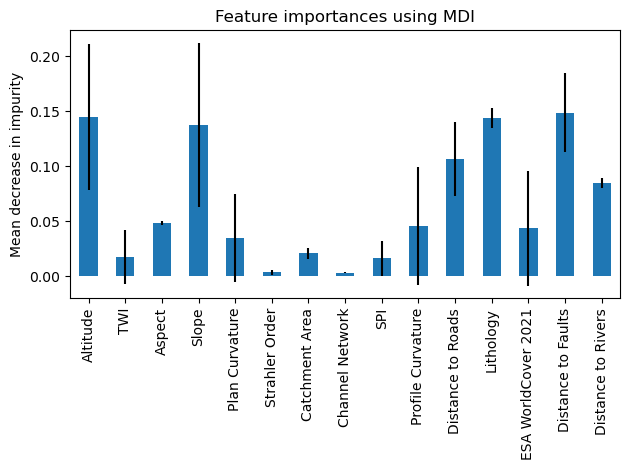

In [5]:
functions.FeatureSet.ShowImportances(f'{ResultDir}', 
                                     ResultVersion, 
                                     Features, 
                                     RFClassifier)

Metrics for Version EU25m-1ls-2nonls-34est-38mxdpth

        
Confusion Matrix
[[232643   4970]
 [  4155 114880]]
        
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    237613
           1       0.96      0.97      0.96    119035

    accuracy                           0.97    356648
   macro avg       0.97      0.97      0.97    356648
weighted avg       0.97      0.97      0.97    356648

        
Accuracy: 0.9744
        
Area Under Curve: 0.9897


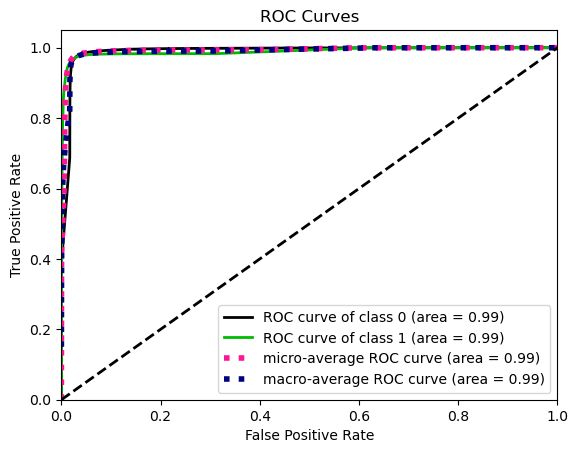

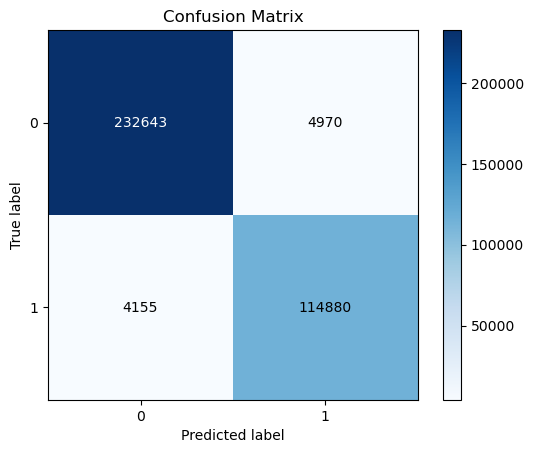

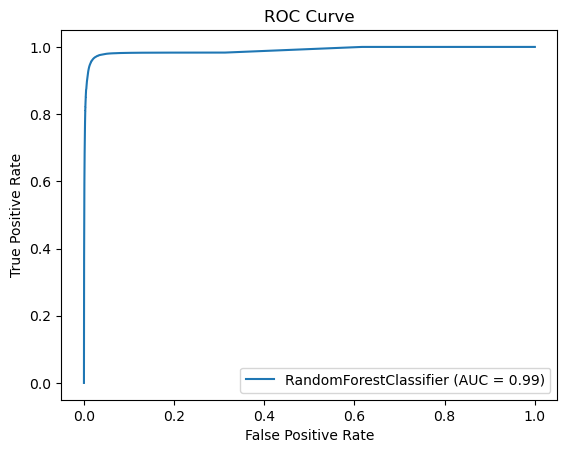

In [6]:
functions.FeatureSet.ShowMetrics(f'{ResultDir}', 
                                 ResultVersion, 
                                 RFClassifier, 
                                 X_test, 
                                 y_test, 
                                 y_pred)

In [7]:
# regr = RandomForestRegressor(max_depth=2, random_state=0)
# regr.fit(X_train_s, y_train_s.ravel())
# y_pred_s=regr.predict(X_test_s)

In [8]:
# Load model from file
# import joblib
# RFClassifierModel = joblib.load('/kaggle/working/RF_LS_Model.pkl')

In [9]:
Classes = [] 
for image in Features:
    cache = tf.imread(image).flatten()
    cache[np.isnan(cache)]=0
    Classes.append(cache.T)
Classes = np.asarray(Classes)

In [10]:
#from numba import jit, cuda
#@jit(target_backend='cuda')
def PredictClassProbabilities(Classifier):
    classProbabilities = Classifier.predict_proba(Classes.T)[:,1]
    return classProbabilities
ClassProbabilities = PredictClassProbabilities(RFClassifier)

In [11]:
cols, rows = 12839, 6880
#cols, rows = functions.FeatureSet.Dimensions(DEMFile)
# no_datas = np.where(np.isnan(tf.imread(DEMFile).flatten())) 
no_datas = np.where(tf.imread(DEMFile).flatten()<0)
ClassProbabilities[no_datas]=-1
data = ClassProbabilities.reshape(rows,cols)
print(data)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.07550026  0.04314266
   0.03824109]
 [ 0.01470942  0.          0.         ...  0.05882353  0.19608157
   0.39511238]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


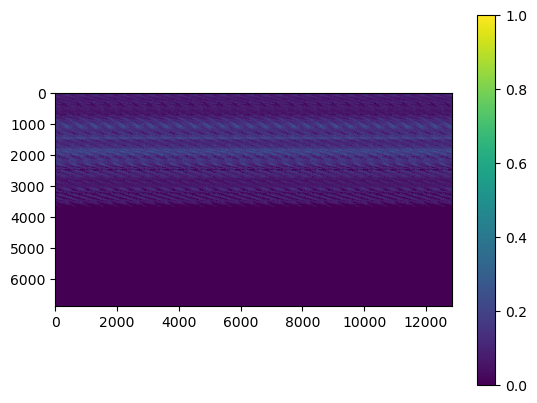

In [12]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.imshow(data, vmin=0, vmax=1, cmap=plt.cm.viridis)
plt.colorbar()
plt.savefig(f'{ResultDir}/RF_ROC_Map', dpi = 600)

In [13]:
#functions.FeatureSet.GeoExport(data, ResultFile, DEMFile, -9999)

In [14]:
import pathlib
import zipfile

directory = pathlib.Path(f'{ResultDir}/')

with zipfile.ZipFile(f'{ResultVersion}.zip', mode="w") as archive:
   for file_path in directory.iterdir():
       archive.write(file_path, arcname=file_path.name)

with zipfile.ZipFile(f'{ResultVersion}.zip', mode="r") as archive:
    archive.printdir()

File Name                                             Modified             Size
RF_ROC_Map.png                                 2023-05-02 18:50:46      2533870
RF_CM_from_estimator.png                       2023-05-02 18:45:42       191153
RF_LS_Model.pkl                                2023-05-02 18:45:32    300920106
RF_CM.png                                      2023-05-02 18:45:38       140478
Metrics.txt                                    2023-05-02 18:45:36          538
RF_ROC.png                                     2023-05-02 18:45:38       376678
Feature_Importance.png                         2023-05-02 18:45:34       355937


In [15]:
def PrintElapsedTime(start_time):
    from datetime import timedelta
    elapsed = time.time() - start_time
    td_str = str(timedelta(seconds=elapsed))
    x = td_str.split(':')
    print(f'{x[0]} saat {x[1]} dakika {x[2]} saniyede tamamlandı.')
PrintElapsedTime(start_time)

0 saat 09 dakika 00.367947 saniyede tamamlandı.
